# Scalers comparison - Supervised
In this notebook I'll compare three common scalers to see the effect on the classification

In [13]:
# Importing main libraries
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from benchtools.src.clustering import build_features
from benchtools.src.datatools import separate_data
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from benchtools.src.datatools import separate_data

# Importing the metrics
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score, balanced_accuracy_score, roc_auc_score, average_precision_score

# Importing the classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Getting the data

I'll pre-process the data using the <code>benchtools</code> package. The next cell just need to be run one time

In [2]:
build_features(path_data='..\..\events_anomalydetection.h5', nbatch=10, outname='RD_dataset')

A file with that name already exists


In [3]:
# Importing the data 
df = pd.read_csv("..\data\RD_dataset.csv")
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


I'm going to separate the table in two: one with the standarized variables and the other with the labels. Then, into a training set and a test set

In [4]:
df_RD = df.sample(100000, random_state = 1)
X, y = separate_data(df_RD, standarize=False)
X_train_m, X_test_m, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Eliminate the columns of mass so that the training is model-free 
X_train = X_train_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X_test = X_test_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

## MinMaxScaler

In [5]:
# Scaling the variables
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [6]:
def supervised_training(classifiers, X_train, y_train, X_test, y_test):
    ii=1
    dic = {}
    log_cols = ["Classifier", "Precision", "Recall", "Log loss", "F1 score", "Balanced accuracy", "AUC score", "Average precision"]
    log = pd.DataFrame(columns=log_cols)
    
    for clf in tqdm(classifiers):
    #for clf in classifiers:

        # Training the classifiers
        clf.fit(X_train, y_train)
        
        # Getting its names
        name = clf.__class__.__name__
    
        # Obtaining predictions
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)

        # Calculating metrics
        precision = precision_score(y_test, y_pred)
        ll = log_loss(y_test, y_prob)
        f1 = f1_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        ba = balanced_accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob[:, 1])
        ap = average_precision_score(y_test, y_prob[:, 1])

        # Inserting into a dictionary
        dic[name]=[recall, precision*100, ll, f1, ba, auc, ap]
        #print('done {}'.format(ii))
        #ii+=1
    
    # Converting it into a dataframe
    columns_name = {'index':'Classifier', 0:'Recall', 1:'Precision', 2:'Log Loss', 3: 'F1 score',
              4:'Balanced accuracy', 5:'AUC score', 6: 'Average precision'}
    log = pd.DataFrame.from_dict(dic, orient='index').reset_index().rename(columns=columns_name)
    return log

In [7]:
# Listing the classifiers to compare
classifiers = [LogisticRegression(max_iter=600),
                KNeighborsClassifier(3, weights='distance'),
                SVC(kernel="rbf", C=0.025, probability=True),
                DecisionTreeClassifier(criterion="entropy", max_depth=3),
                RandomForestClassifier(),
                AdaBoostClassifier(),
                GradientBoostingClassifier(),
                GaussianNB(),
                LinearDiscriminantAnalysis(),
                QuadraticDiscriminantAnalysis(), 
                MLPClassifier()]

In [8]:
log_mms = supervised_training(classifiers, X_train, y_train, X_test, y_test)

  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Comparing the metrics simultaneously for all algorithms: 

In [10]:
def bar_comparison(data, x, color):
    sns.set_color_codes("muted")
    sns.barplot(x=x, y='Classifier', data=data, color=color)
    plt.xlabel('{}'.format(x))
    plt.title('Classifiers:{}'.format(x))
    plt.show()

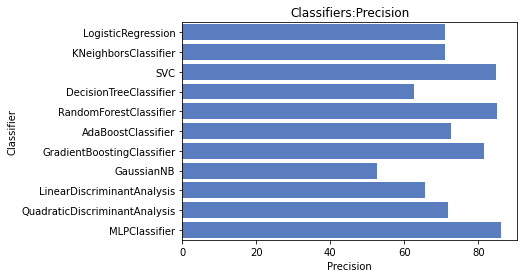

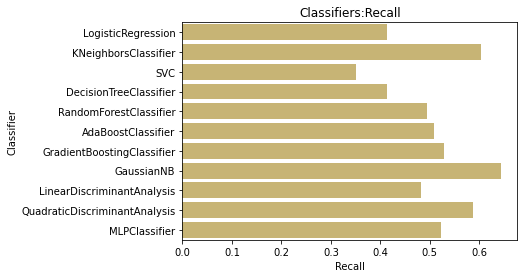

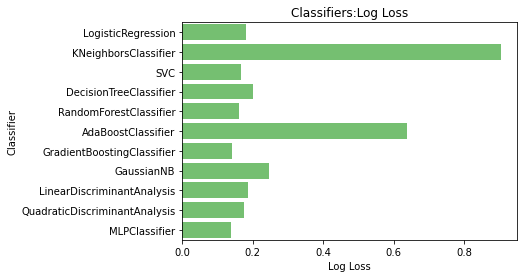

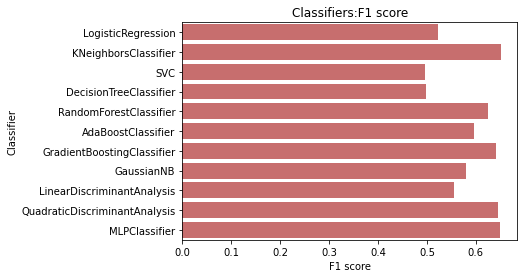

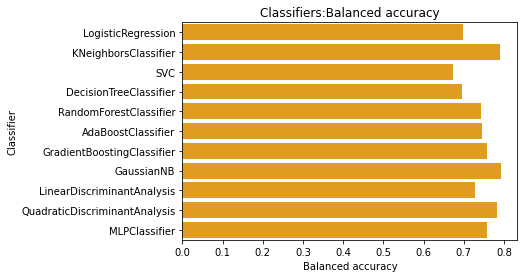

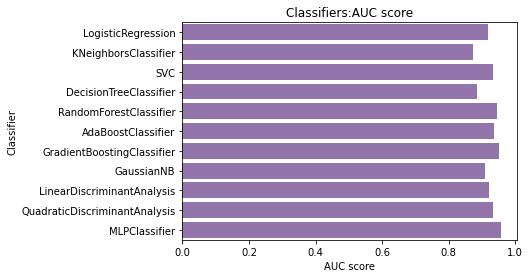

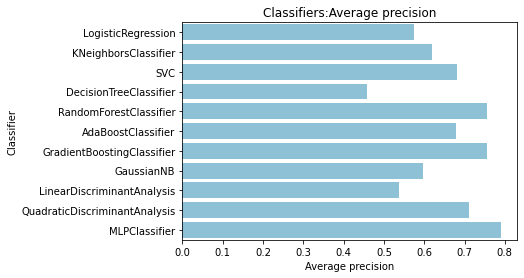

In [20]:
x_list = ['Precision', 'Recall', 'Log Loss', 'F1 score', 'Balanced accuracy', 'AUC score', 'Average precision']
color_list = ['b', 'y', 'g', 'r', 'orange', 'm', 'c', 'hotpink']

for x, color in zip(x_list, color_list):
    bar_comparison(data=log_mms, x=x, color=color)

## StandardScaler

In [21]:
# Getting the variables again
X, y = separate_data(df_RD, standarize=False)
X_train_m, X_test_m, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Eliminate the columns of mass so that the training is model-free 
X_train = X_train_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X_test = X_test_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

# Scaling
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [15]:
log_ss = supervised_training(classifiers, X_train, y_train, X_test, y_test)

  0%|          | 0/11 [00:00<?, ?it/s]

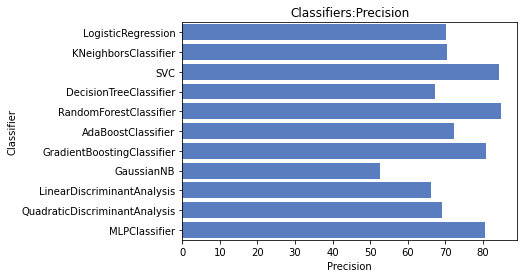

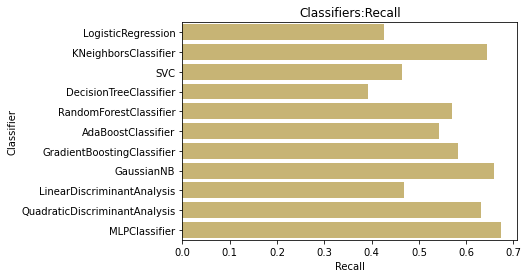

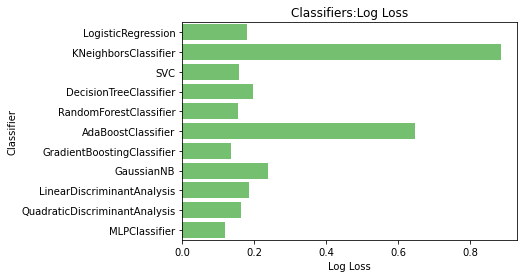

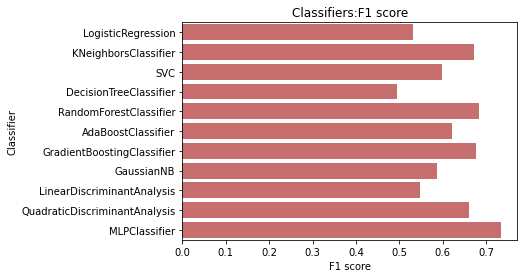

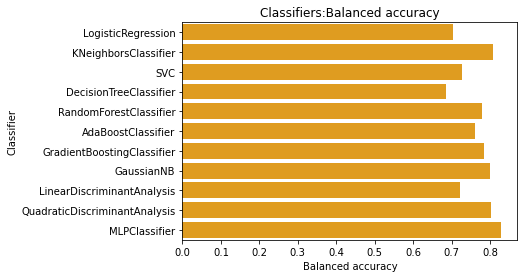

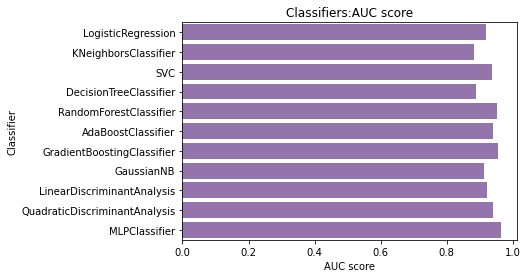

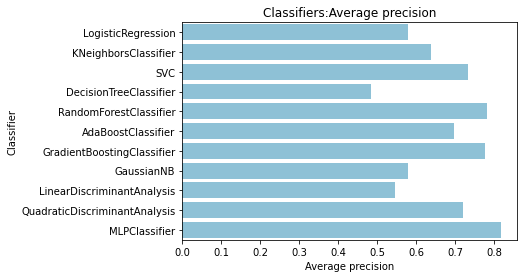

In [22]:
for x, color in zip(x_list, color_list):
    bar_comparison(data=log_ss, x=x, color=color)

## RobustScaler

In [17]:
# Getting the variables again
X, y = separate_data(df_RD, standarize=False)
X_train_m, X_test_m, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Eliminate the columns of mass so that the training is model-free 
X_train = X_train_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X_test = X_test_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

#Scaling
scaler = RobustScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [18]:
log_rs = supervised_training(classifiers, X_train, y_train, X_test, y_test)

  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


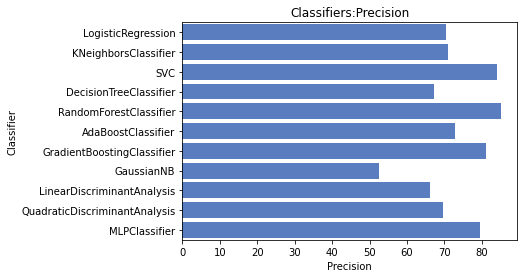

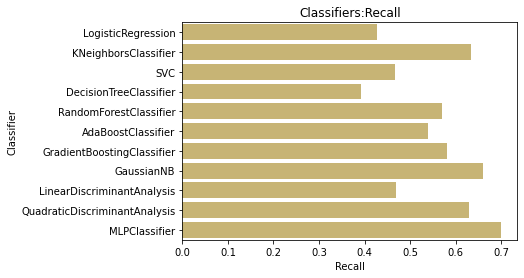

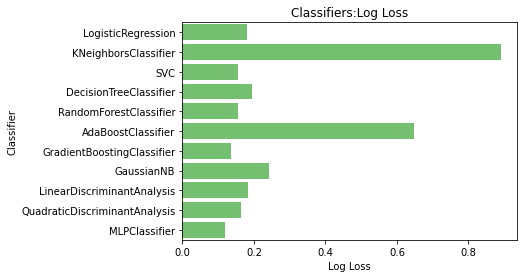

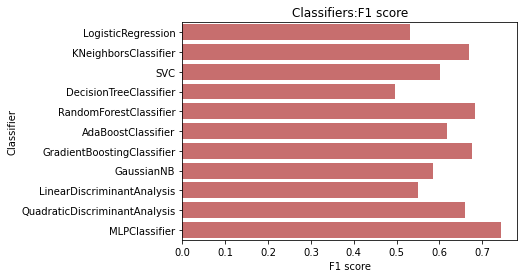

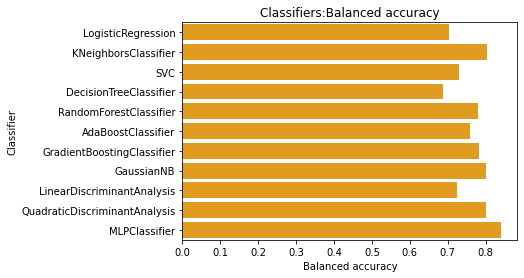

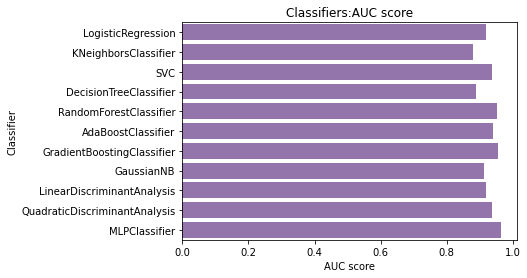

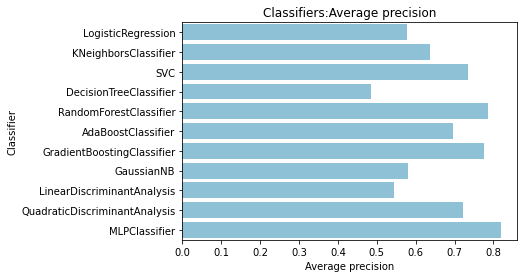

In [23]:
for x, color in zip(x_list, color_list):
    bar_comparison(data=log_rs, x=x, color=color)

In [25]:
log_rs.mean(axis=0)

<ipython-input-25-c0208a8b564b>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  log_rs.mean(axis=0)


Recall                0.551934
Precision            72.630114
Log Loss              0.278584
F1 score              0.619577
Balanced accuracy     0.764895
AUC score             0.928605
Average precision     0.668998
dtype: float64

In [26]:
log_mms.mean(axis=0)

<ipython-input-26-67ac01d65e34>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  log_mms.mean(axis=0)


Recall                0.504532
Precision            73.118586
Log Loss              0.285350
F1 score              0.587750
Balanced accuracy     0.742007
AUC score             0.924229
Average precision     0.650915
dtype: float64

In [27]:
log_ss.mean(axis=0)

<ipython-input-27-87eb801b4607>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  log_ss.mean(axis=0)


Recall                0.550591
Precision            72.682840
Log Loss              0.277803
F1 score              0.618948
Balanced accuracy     0.764265
AUC score             0.928651
Average precision     0.668311
dtype: float64